In [26]:
from curses import flash
import os
from pickle import TRUE
from re import L
import requests
import validators
import gzip
import shutil
from urllib.parse import urlparse

import sys
import math
import xarray as xa
import numpy as np
from rio_cogeo import cog_validate
import rioxarray

# Mapping
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [27]:
file_location1 = "/home/asubedi/Desktop/data/raw-files/GLM/OR_GLM-L3-GLMF-M6_G16_s202315823490000_e202315823500000_c20231582351080.nc"
variable1 = "Flash_extent_density"
file1 = xa.open_dataset(file_location1, engine="netcdf4", decode_coords='all', decode_times=False)
#radius of Earth at the equator in meters
r_eq = file1['goes_imager_projection'].semi_major_axis

#radius of Earth at the pole in meters
r_pol = file1['goes_imager_projection'].semi_minor_axis

#distance from satellite to earth center in meters
H = file1['goes_imager_projection'].perspective_point_height+r_eq

#longitude of projection origin in units of radians
lon0 = file1['goes_imager_projection'].longitude_of_projection_origin * (math.pi/180.)

In [28]:
lat_path = "/home/asubedi/Desktop/work/GLM_GHRCCLOUD-4803/src/lat_avg3.txt"
lon_path = "/home/asubedi/Desktop/work/GLM_GHRCCLOUD-4803/src/lon_avg33.txt"
with open(lat_path, 'r') as file:
    file_contents = file.read()
lat_glmtools = file_contents.split()

with open(lon_path, 'r') as file:
    file_contents = file.read()
lon_glmtools = file_contents.split()

In [29]:
np_lat_glmtools = np.zeros(len(lat_glmtools))
np_lon_glmtools = np.zeros(len(lon_glmtools))

In [30]:
#load lat into np array
for i in range(len(lat_glmtools)):
    np_lat_glmtools[i] = float(lat_glmtools[i])

In [31]:
#load lon into np array
for i in range(len(lon_glmtools)):
    np_lon_glmtools[i] = float(lon_glmtools[i])

In [32]:
print(np_lat_glmtools)
print(np_lon_glmtools)

[-999. -999. -999. ... -999. -999. -999.]
[-155.83723669 -155.00118522 -154.52063757 ...    4.52063757    5.00118522
    5.83723669]


In [34]:
def calc_lat_lon(xx,yy):
    #intermediate calculations
    a = (math.sin(xx))**2 + (math.cos(xx))**2 * ((math.cos(yy))**2 + r_eq**2/r_pol**2*(math.sin(yy))**2)
    b = -2 * H * math.cos(xx) * math.cos(yy)
    c = H**2 - r_eq**2

    if b**2-4*a*c < 0:
       lat = -999.
       lon = -999.
    else:
       #distance from the satellite to point P
       r_s = (-b-math.sqrt(b**2-4*a*c))/2/a

       #derived using satellite location and earth geometry s_x, s_y, s_z
       s_x = r_s * math.cos(xx) * math.cos(yy)
       s_y = -r_s * math.sin(xx)
       s_z = r_s * math.cos(xx) * math.sin(yy)

       #geodetic latitude and longitude for point P
       #math.atan(x) return the arc tangent of x, in radians. The result is between -pi/2 and pi/2
       lat = math.atan(((r_eq**2)/(r_pol**2)) * (s_z/math.sqrt((H-s_x)**2 + s_y**2))) #radians
       lon = lon0 - math.atan(s_y/(H-s_x)) #radians

       #convert radians to degrees
       lat = lat * 180./math.pi #degree
       lon = lon * 180./math.pi #degree

    return lat, lon

x_cpy = file1.x.copy()
y_cpy = file1.y.copy()

lat = np.zeros(file1.x.size)
lon = np.zeros(file1.x.size)
data = file1[variable1].data.copy()


for i in range(x_cpy.size):
    lat[i], lon[i] = calc_lat_lon(x_cpy[i], y_cpy[i])

In [35]:
lat = np_lat_glmtools
lon = np_lon_glmtools

_lat = np_lat_glmtools.copy()
_lon = np_lon_glmtools.copy()
_data = file1[variable1].data.copy()

end_index = len(lon)
for index, value in np.ndenumerate(lon[::-1]):
    end_index -= 1
    if value == -999.0:
        _data = np.delete(_data, end_index, axis=0)
        _lon = np.delete(_lon, end_index)

end_index = len(lat)
for index, value in np.ndenumerate(lat[::-1]):
    end_index -= 1
    if value == -999.0:
        _data = np.delete(_data, end_index, axis=1)
        _lat = np.delete(_lat, end_index)

In [36]:
print(_data.shape)
print(len(_lon))
print(len(_lat))

(5424, 5406)
5424
5406


In [38]:
# file1[variable1].data = _data
# file1 = file1.assign_coords(x=_lon, y=_lat)

file2 = xa.Dataset(
    data_vars={"Flash_extent_density": (("lon", "lat"), _data)},
    coords={"lon": _lon, "lat": _lat},
    attrs={"instrument_ID": "GLM-1"}
)

In [39]:
file2

<xarray.Dataset>
Dimensions:               (lon: 5424, lat: 5406)
Coordinates:
  * lon                   (lon) float64 -155.8 -155.0 -154.5 ... 5.001 5.837
  * lat                   (lat) float64 80.78 79.96 79.45 ... -79.96 -80.78
Data variables:
    Flash_extent_density  (lon, lat) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    instrument_ID:  GLM-1

In [166]:
# file1

In [40]:
frd = file2[variable1]

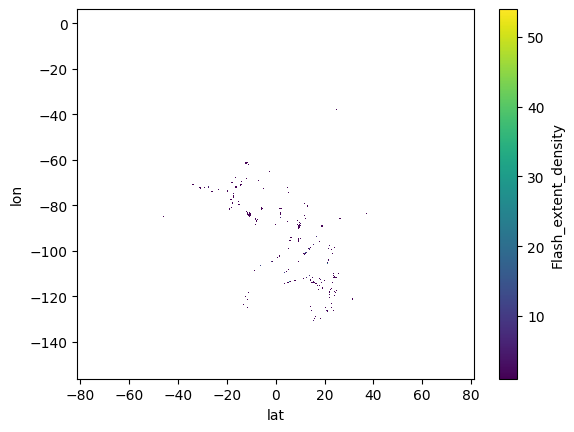

In [41]:
frd.plot()

In [42]:
import random
#converting to COG
frd = frd.transpose("lat","lon")
# file1.plot()
frd.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
frd.rio.crs
frd.rio.set_crs('epsg:4326', inplace=True)

name=f"S2A_20160724_135032_27XVB_B{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}.tif"
cog_name = f"testing{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}.nc"
print(name, cog_name)
cog_path=f"/home/asubedi/Desktop/test/{name}"
frd.rio.to_raster(rf'{cog_path}', driver='COG')

S2A_20160724_135032_27XVB_B354.tif testing041.nc


In [43]:
frd.to_netcdf(cog_name)